# RNSA 2023 EDA

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import glob
import os
import pydicom
from tqdm import tqdm
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

## - train.csv file

**train.csv** Target labels for the train set. Note that patients labeled healthy may still have other medical issues, such as cancer or broken bones, that don't happen to be covered by the competition labels.
* `patient_id` - A unique ID code for each patient.
* `[bowel/extravasation]_[healthy/injury]` - The two injury types with binary targets.
* `[kidney/liver/spleen]_[healthy/low/high` - The three injury types with three target levels.
* `any_injur` - Whether the patient had any injury at all.


We can see that we have **3147** different patients and one hot encodings as labels. First let's see the correlation matrix between the injuries.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5



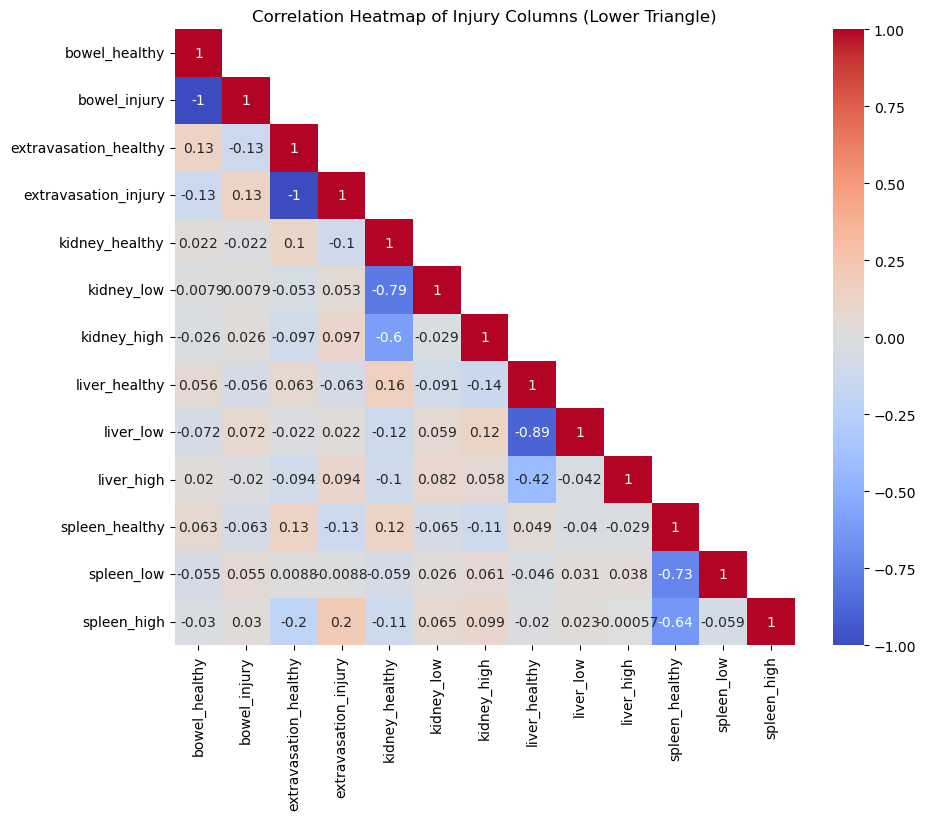

In [2]:
from scipy.stats import pointbiserialr
import seaborn as sns

main_folder = "/kaggle/input/rsna-2023-abdominal-trauma-detection/"
train = pd.read_csv(main_folder + "train.csv")

injury_columns = train.columns[1:-1]

correlation_matrix = pd.DataFrame(index=injury_columns, columns=injury_columns)

for col1 in injury_columns:
    for col2 in injury_columns:
        # Convert categorical values to numeric using Point Biserial Correlation
        r, _ = pointbiserialr(train[col1], train[col2])
        correlation_matrix.loc[col1, col2] = r

mask = np.triu(np.ones(correlation_matrix.shape), k=1)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', center=0, mask=mask)
plt.title('Correlation Heatmap of Injury Columns (Lower Triangle)')
plt.show()

Now let's see how the injuries are distributed among the patients. But first let's modify the shape of the dataframe.

In [3]:
train['bowel'] = train.iloc[:, 1:3].idxmax(1)
train['extravasation'] = train.iloc[:, 3:5].idxmax(1)
train['kidney'] = train.iloc[:, 5:8].idxmax(1)
train['liver'] = train.iloc[:, 8:11].idxmax(1)
train['spleen'] = train.iloc[:, 11:14].idxmax(1)

train = train.drop(columns =['bowel_healthy','bowel_injury','extravasation_healthy','extravasation_injury','kidney_healthy','kidney_low','kidney_high','liver_healthy','liver_low','liver_high',
                             'spleen_healthy','spleen_low','spleen_high'])
train.head()

,patient_id,any_injury,bowel,extravasation,kidney,liver,spleen
0,10004,1,bowel_healthy,extravasation_injury,kidney_low,liver_healthy,spleen_high
1,10005,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
2,10007,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
3,10026,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
4,10051,1,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_low


Let's replace bowel_healthy with 0, bowel_injury with 1, same for extravasation and 0 to 2 for healthy-low-high.

In [4]:
train['bowel'] = train['bowel'].replace(['bowel_injury','bowel_healthy'], [1, 0])
train['extravasation'] = train['extravasation'].replace(['extravasation_injury', 'extravasation_healthy'], [0, 1])
train['kidney'] = train['kidney'].replace(['kidney_low','kidney_high','kidney_healthy'], [1, 2, 0])
train['liver'] = train['liver'].replace(['liver_low','liver_high','liver_healthy'], [1, 2, 0])
train['spleen'] = train['spleen'].replace(['spleen_low','spleen_high','spleen_healthy'], [1, 2, 0])

train.head()

,patient_id,any_injury,bowel,extravasation,kidney,liver,spleen
0,10004,1,0,0,1,0,2
1,10005,0,0,1,0,0,0
2,10007,0,0,1,0,0,0
3,10026,0,0,1,0,0,0
4,10051,1,0,1,0,0,1


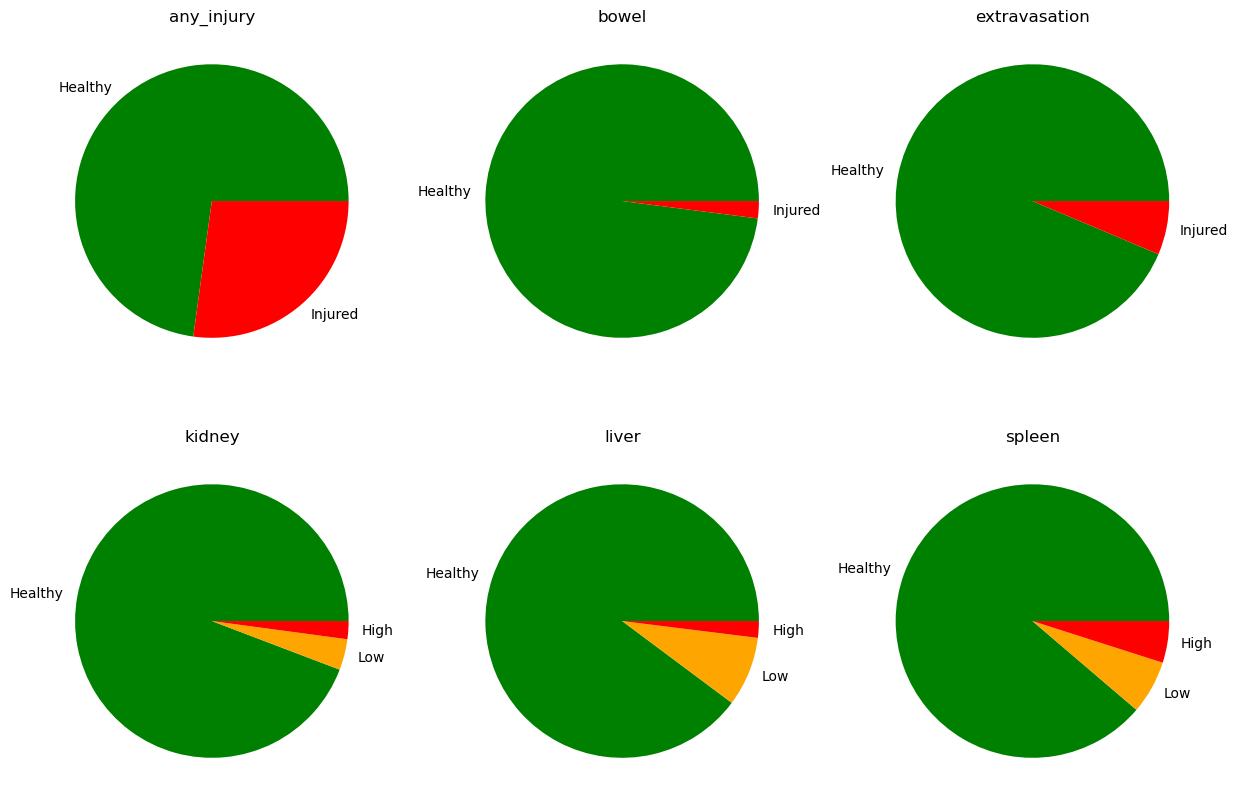

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for idx, column in enumerate(train.columns[1:]):
    axes[idx].set_axis_off()
    ax = axes[idx]
    possible_values = train[column].nunique()
    if possible_values == 2:
        labels = ['Healthy', 'Injured']
        color_discrete_sequence = ['g','r']
        sizes = train[column].value_counts().to_dict()
    else:
        labels = ['Healthy', 'Low', 'High']
        color_discrete_sequence = ['g', 'orange', 'r']
        sizes = train[column].value_counts().to_dict()
    ax.pie(sizes.values(), labels=labels, colors=color_discrete_sequence)
    ax.set_title(column)
plt.show()

## - train_series_meta.csv / test_series_meta.csv

### train

In [6]:
train_series_meta = pd.read_csv(main_folder + "train_series_meta.csv")
train_series_meta.head()

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


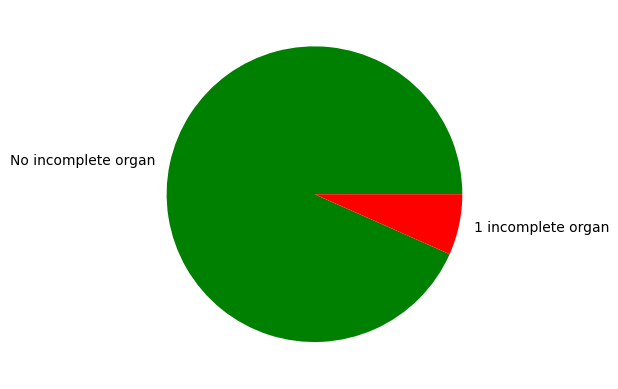

In [7]:
sizes = train_series_meta['incomplete_organ'].value_counts().to_dict()
color_discrete_sequence = ['g','r']
labels = ['No incomplete organ', '1 incomplete organ']
fig, ax = plt.pie(sizes.values(), labels=labels, colors=color_discrete_sequence)

A incomplete organ means that it's **croped** on the image.

In [8]:
print("Number of Unique Values:\n",train_series_meta.nunique())

Number of Unique Values:
 patient_id          3147
series_id           4711
aortic_hu            717
incomplete_organ       2
dtype: int64


In [9]:
id_counts = train_series_meta['patient_id'].value_counts()

# Filter out IDs that are duplicated less than two times
filtered_id_counts = id_counts[id_counts >= 2]

print("Number of patients that have two series :", len(filtered_id_counts))


Number of patients that have two series : 1564


Now let's check if there's a link between injury and and value of the **aortic** measure. If there is a negative value in the dataset, we take its positive value.

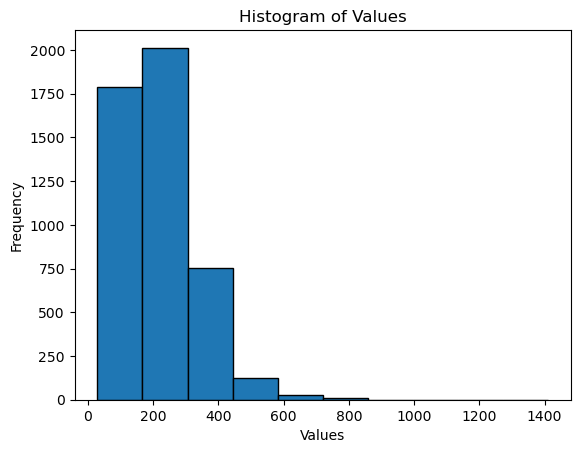

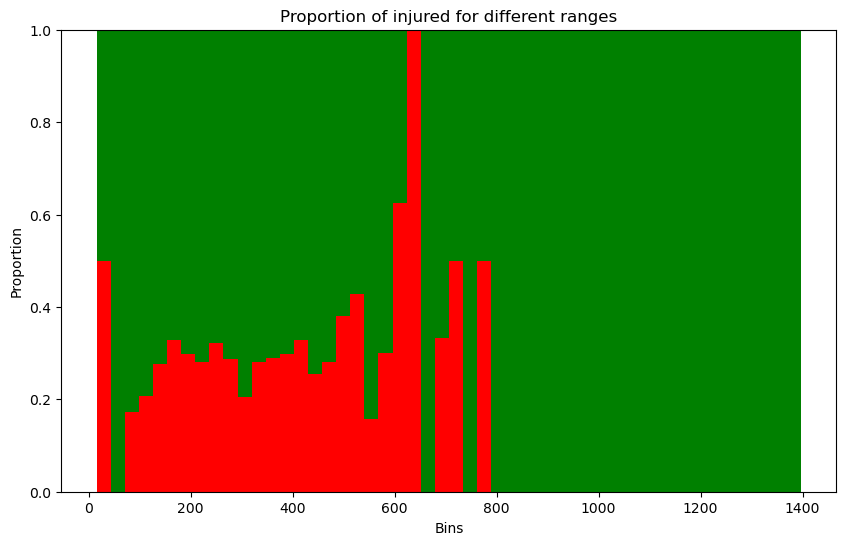

In [10]:
c = train_series_meta['aortic_hu']

train_series_meta['aortic_hu'] = c.apply(lambda x: abs(x))

column_to_plot = train_series_meta['aortic_hu']
plt.hist(column_to_plot, bins=10, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values')


merged_df = train_series_meta.merge(train[['patient_id', 'any_injury']], on='patient_id', how='left')

num_datasets = 50

min_aortic = merged_df['aortic_hu'].min()
max_aortic = merged_df['aortic_hu'].max()
bins = [min_aortic + i * (max_aortic - min_aortic) / num_datasets for i in range(num_datasets + 1)]

merged_df['dataset'] = pd.cut(merged_df['aortic_hu'], bins=bins, labels=range(1, num_datasets + 1))

datasets = {}
for i in range(1, num_datasets + 1):
    datasets[i] = merged_df[merged_df['dataset'] == i].drop(columns=['dataset'])

heights_injury = [dataset['any_injury'].sum() / max(1,dataset.shape[0]) for dataset in datasets.values()]

bin_widths = [bins[i+1] - bins[i] for i in range(len(bins)-1)]

fig, ax = plt.subplots(figsize=(10, 6))

for i, (bin_val, height) in enumerate(zip(bins[:-1], heights_injury)):
    ax.bar(bin_val, height, width=bin_widths[i], color='red')
    ax.bar(bin_val, 1 - height, bottom=height, width=bin_widths[i], color='green')

ax.set_xlabel('Bins')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of injured for different ranges')

# Show the plot
plt.show()





We can see that all the aortic_hu value is quite independant from the health of the patients.
So our training model would not include the inforamation of **aortic** measure.